LSTM_out 20
Dense_out 1


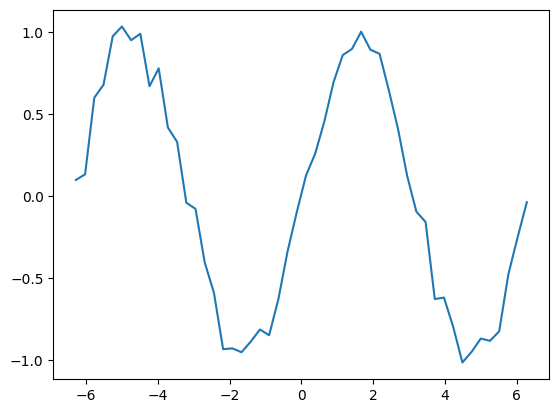

In [12]:
import matplotlib.pyplot as plt
import math
import random

n_time =10 #int(input("한번에 고려할 시점 수:")) #한번에 고려할 시점의 개수
n_in = 1
n_mid = 20
n_out = 1
print('LSTM_out',n_mid)
print('Dense_out',n_out)

eta = 0.01
epochs = 101
batch_size = 8 #int(input("배치 사이즈:"))
interval = 10  # # 경과 표시 간격

pi = 3.14159265358979
num_data_points = 50#*4 #np.linspace()기본이 50개
sin_x = []
sin_y = []
start = -2*pi#*4
finsih = 2*pi#*4
for i in range(num_data_points): # 1부터 num_data_points까지
    now_x = start +(finsih-start)*(i/(num_data_points-1)) # start, finsih 포함해서 50개 점 이므로 num_data_points-1(전체 -1)
    sin_x.append(now_x)
    now_y = math.sin(now_x) + 0.1*random.gauss(0, 1)
    sin_y.append(now_y)

plt.plot(sin_x,sin_y)
plt.show()

n_sample = len(sin_x)-n_time
input_data = [[[0 for i in range(n_in)] for j in range(n_time)]for k in range(n_sample)]
correct_data = [[0 for i in range(n_out)] for j in range(n_sample)]
for i in range(0,n_sample):
    n_time_x =[]
    for j in range(n_time):
        n_time_x.append([sin_y[i+j]]) # 과거 n_time의 sin_y 값을 입력으로 저장
    input_data[i] = n_time_x
    correct_data[i] = sin_y[i+n_time:i+n_time+1]

In [13]:
def activation(function,x):
    e = 2.718281828459045 #자연상수:2.71828182845904523536
    result = []
    if(function == 'Sigmoid'):
        for i in range(len(x)):
            row = []
            for j in range(len(x[0])):
                now_x = x[i][j]
                row.append((e**now_x)/((e**now_x)+1)) #C언어에서는 **이 없어 **도 구현
            result.append(row)
        return result
    if(function == 'Tanh'):
        for i in range(len(x)):
            row = []
            for j in range(len(x[0])):
                now_x = x[i][j]
                row.append((2/(1+(e**(-2*now_x))))-1)
            result.append(row)
        return result
    if(function == 'ReLU'):
        for i in range(len(x)):
            row = []
            for j in range(len(x[0])):
                now_x = x[i][j]
                if (now_x<=0):
                    row.append(0)
                else:
                    row.append(now_x)
            result.append(row)
        return result
    if(function == 'Equl'):
        return x
    
def matrix_product(A, B):
    if type(A[0]) != list:
        A = [A]

    if len(A[0]) != len(B):
        raise ValueError("행렬 곱 연산이 불가능합니다.")

    result = [[0 for i in range(len(B[0]))] for j in range(len(A))]
    for i in range(len(A)):
        for j in range(len(B[0])):
            dot_product = 0
            for k in range(len(A[0])):
                dot_product += A[i][k] * B[k][j]
            result[i][j] = dot_product
    return result
def element_cal_2d(arr1, operator, arr2):
    if len(arr1) != len(arr2)  or len(arr1[0]) != len(arr2[0]):
        raise ValueError("Input arrays must have the same shape")
    result = []
    for i in range(len(arr1)):
        row = []
        for j in range(len(arr1[0])):
            if(operator == '+'):
                row.append(arr1[i][j] + arr2[i][j])
            elif(operator == '*'):
                row.append(arr1[i][j] * arr2[i][j])
            elif(operator == '-'):
                row.append(arr1[i][j] - arr2[i][j])
        result.append(row)
    
    return result

def element_sum_3d(arr1, arr2): # 3차원 배열 2개를 같은 자리의 원소끼리 합한 3차원 배열로 반환
    if len(arr1) != len(arr2)  or len(arr1[0]) != len(arr2[0]) or len(arr1[0][0]) != len(arr2[0][0]):
        raise ValueError("Input arrays must have the same shape")
    result = []
    for i in range(len(arr1)):
        row_1 = []
        for j in range(len(arr1[0])):
            row_2 = []
            for k in range(len(arr1[0][0])):
                row_2.append(arr1[i][j][k] + arr2[i][j][k])
            row_1.append(row_2)
        result.append(row_1)

    return result
def insert_slice_3d(insert,orign,column_index):
    cnt = 0
    for row in orign:
        row[column_index] = insert[cnt]
        cnt += 1
    return orign
    
def insert_slice_4d(insert,orign,column_index):
    cnt_0 = 0
    for index_0 in orign:
        cnt_1 = 0
        for index_1 in index_0:
            index_1[column_index] = insert[cnt_0][cnt_1]
            cnt_1 += 1
        cnt_0 += 1
    return orign
def transpose_matrix(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    # 전치 행렬을 저장할 빈 리스트 생성
    transposed = [[0 for i in range(rows)] for j in range(cols)]
    
    # 행과 열 바꾸기
    for i in range(rows):
        for j in range(cols):
            transposed[j][i] = matrix[i][j]
    
    return transposed
def Sum_1D(arr): #열벡터인(m,1) 원소의 합을 1차원 배열로 반환 
    sum = 0
    for i in arr:
        sum += i[0]
    return [sum]

def Sum_3D(arr,axis): #3차원 배열을 axis방향으로 합해서 이차원 배열 반환
    if (axis == 0):
        prev = like_2d(arr[0],0)
        for i in range(len(arr)):
            now = element_cal_2d(arr[i],'+',prev)
            prev = now
        return now
    if (axis == 1):
        result = []
        for i in range(len(arr)):
            element_1 = []
            for j in range(len(arr[0][0])):
                num_1 = 0
                for k in range(len(arr[0])):
                    num_1 += arr[i][k][j]
                element_1.append(num_1)
            result.append(element_1)
        return result
# 어떤 크기의 함수와 같은 크기 만드는 함수 원소는 num으로 채움
def like_2d(array,num):
    result=[]
    for index in array:
        cnt = []
        for j in index:
                cnt.append(num)
        result.append(cnt)
    return result
    
def like_3d(array,num):
    result=[]
    for index_1 in array:
        cnt_1 = []
        for index_2 in index_1:
            cnt_2 = []
            for index_3 in index_2:
                cnt_2.append(num)
            cnt_1.append(cnt_2)        
        result.append(cnt_1)
    return result
def custom_slice_3d(array, column_index):
    result = []
    for row in array:
        result.append(row[column_index])
    return result

def custom_slice_4d(array, dimension_index):
    result = []
    for index_0 in array:
        arr_1 = []
        for index_1 in index_0:
            arr_1.append(index_1[dimension_index])
        result.append(arr_1)
    return result


In [14]:
class LSTMLayer:
    def __init__(self,n_upper,n):
        #가중치 초기화: 가우시안 초기화 방법,  He 초기화 (He Initialization) 또는 Xavier 초기화 (Glorot Initialization)도 존재
        self.w = []
        self.v = []
        self.b = []
        for _ in range(4): ## 망각 게이트,입력 게이트,새로운 기억, 출력 게이트 총 4개에서 업데이트 해야함
            w0=[[random.gauss(0,1) for i in range(n)] for j in range(n_upper)] # X는 (시점 수, 특징 수)이므로 w 는 (특징수, output_size) 
            v0=[[random.gauss(0,1) for i in range(n)]for j in range(n)]  # Y는 (시점 수, 특징 수)이므로 w 는 (특징수, output_size)
            b0=[0 for i in range(n)] 
            self.w.append(w0)
            self.v.append(v0)
            self.b.append(b0)
 
    def forward(self, x, y_prev, c_prev):
        reshape_b = []
        for i in range(4):
            reshape_b.append([self.b[i] for _ in range(len(x))])

        u = []
        for i in range(4):
            Xw = matrix_product(x, self.w[i])
            Yv = matrix_product(y_prev, self.v[i])
            Xw_Yv = element_cal_2d(Xw,'+',Yv)
            u.append(element_cal_2d(element_cal_2d(Xw,'+',Yv),'+',reshape_b[i]))

        a0 = activation('Sigmoid',u[0])  # 망각 게이트
        a1 = activation('Sigmoid',u[1])  # 입력 게이트
        a2 = activation('Tanh',u[2])  # 새로운 기억
        a3 = activation('Sigmoid',u[3])  # 출력 게이트

        self.gates = []
        self.gates.append(a0)
        self.gates.append(a1)
        self.gates.append(a2)
        self.gates.append(a3)
        self.c = element_cal_2d(element_cal_2d(a0,'*',c_prev),'+',element_cal_2d(a1,'*',a2))
        tanh_c = activation('Tanh',self.c)
        self.y = element_cal_2d(a3,'*',tanh_c)  

    def reset_sum_grad(self):

        self.grad_w = like_3d(self.w,0)
        self.grad_v = like_3d(self.v,0)
        self.grad_b = like_2d(self.b,0)

    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c):
        a0 = gates[0]
        a1 = gates[1]
        a2 = gates[2]
        a3 = gates[3]
        tanh_c = activation('Tanh',c)
        martrix_1=[]
        for i in tanh_c:
            new_c=[]
            for j in tanh_c[0]:
                new_c.append(1)
            martrix_1.append(new_c)
        r = element_cal_2d(grad_c,'+',element_cal_2d(element_cal_2d(grad_y,'*',a3),'*',element_cal_2d(martrix_1,'-',element_cal_2d(tanh_c,'*',tanh_c))))
        delta_a0 = element_cal_2d(element_cal_2d(element_cal_2d(r ,'*',c_prev),'*', a0),'*',element_cal_2d(martrix_1,'-',a0))
        delta_a1 = element_cal_2d(element_cal_2d(element_cal_2d(r ,'*',a2),'*', a1),'*',element_cal_2d(martrix_1,'-',a1))
        delta_a2 = element_cal_2d(element_cal_2d(r ,'*',a1) ,'*',element_cal_2d(martrix_1,'-',element_cal_2d(a2,'*',a2)))
        delta_a3 = element_cal_2d(element_cal_2d(element_cal_2d(grad_y,'*',tanh_c),'*',a3),'*',element_cal_2d(martrix_1,'-',a3))

        deltas = []
        deltas.append(delta_a0)
        deltas.append(delta_a1)
        deltas.append(delta_a2)
        deltas.append(delta_a3)

        add_grad_w = []
        for i in range(4):
            add_grad_w.append(matrix_product(transpose_matrix(x),deltas[i]))
        self.grad_w = element_sum_3d(self.grad_w,add_grad_w)

        add_grad_v = []
        for i in range(4):
            add_grad_v.append(matrix_product(transpose_matrix(y_prev),deltas[i]))
        self.grad_v = element_sum_3d(self.grad_v,add_grad_v)
    
        self.grad_b = element_cal_2d(self.grad_b,'+',Sum_3D(deltas,axis=1))
        
        grad_x = []
        for i in range(4):
            grad_x.append(matrix_product(deltas[i],transpose_matrix(self.w[i])))
        self.grad_x = Sum_3D(grad_x,axis=0)

        grad_y_prev = []
        for i in range(4):
            grad_y_prev.append(matrix_product(deltas[i],transpose_matrix(self.v[i])))
        self.grad_y_prev = Sum_3D(grad_y_prev,axis=0)

        self.grad_c_prev = element_cal_2d(r,'*',a0)
    
    def update(self, eta):
        w_eta = like_2d(self.grad_w[0],eta)
        new_w = []
        for i in range(len(self.grad_w)):
            new_w.append(element_cal_2d(self.w[i],'-', element_cal_2d(w_eta,'*',self.grad_w[i])))
        self.w = new_w
        v_eta = like_2d(self.grad_v[0],eta)
        new_v = []
        for i in range(len(self.grad_v)):
            new_v.append(element_cal_2d(self.v[i] ,'-', element_cal_2d(v_eta,'*', self.grad_v[i])))
        self.v = new_v
        b_eta = like_2d(self.grad_b,eta)
        self.b = element_cal_2d(self.b ,'-', element_cal_2d(b_eta,'*', self.grad_b))

In [15]:
class OutputLayer:
    def __init__(self,n_upper,n):
        #가중치 초기화: 가우시안 초기화 방법,  He 초기화 (He Initialization) 또는 Xavier 초기화 (Glorot Initialization)도 존재
        self.w = [[random.gauss(0,1) for i in range(n)] for j in range(n_upper)]
        self.b = [random.gauss(0,1) for i in range(n)]
        #print("Dw",np.array(self.w).shape)
        #print("Db",np.array(self.b).shape)

    def forward(self,x):
        self.x = x
        reshape_b = [self.b for i in range(len(x))]
        u = element_cal_2d(matrix_product(x, self.w),'+', reshape_b)
        self.y = activation('Equl',u)
  
    def backward(self, t):
        delta = element_cal_2d(self.y,'-',t)
        self.grad_w = matrix_product(transpose_matrix(self.x),delta)
        self.grad_b = Sum_1D(delta)
        self.grad_x = matrix_product(delta,transpose_matrix(self.w))
    
    def update(self,eta):
        w_eta = like_2d(self.grad_w,eta)
        self.w = element_cal_2d(self.w,'-',element_cal_2d(w_eta,'*',self.grad_w))
    
        b_eta = [eta for i in range(len(self.grad_b))]
        new_b = []
        for i in range(len(self.grad_b)):
            new_b.append(self.b[i]-(b_eta[i]*self.grad_b[i]))
        self.b = new_b

In [16]:
lstm_layer = LSTMLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [17]:
def train(x_mb, t_mb):
    y_rnn = [[[0 for i in range(n_mid)] for j in range(n_time+1)] for _ in range(len(x_mb))] # 실제 값은 X의 입력 만큼 있어야 하므로
    c_rnn = [[[0 for i in range(n_mid)] for j in range(n_time+1)] for _ in range(len(x_mb))] # X은 시점 수 만큼 있어야 하므로
    gates_rnn = [[[[0 for i in range(n_mid)] for j in range(n_time)] for _ in range(len(x_mb))] for k in range(4)]

    y_prev = custom_slice_3d(y_rnn, 0)
    c_prev = custom_slice_3d(c_rnn, 0)

    for i in range(n_time):
        x = custom_slice_3d(x_mb, i)

        lstm_layer.forward(x, y_prev, c_prev)
    
        y = lstm_layer.y
        y_rnn = insert_slice_3d(y,y_rnn,i+1)
        y_prev = y
        c = lstm_layer.c
        c_rnn = insert_slice_3d(c,c_rnn,i+1)
        c_prev = c
        
        gates = lstm_layer.gates
        gates_rnn = insert_slice_4d(gates,gates_rnn,i)
        
    output_layer.forward(y)

    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = like_2d(lstm_layer.c,0)
    
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = custom_slice_3d(x_mb, i)
        y = custom_slice_3d(y_rnn, i+1)
        c = custom_slice_3d(c_rnn, i+1)
        y_prev = custom_slice_3d(y_rnn, i)
        c_prev = custom_slice_3d(c_rnn, i)
        gates = custom_slice_4d(gates_rnn, i)
    
        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev

    lstm_layer.update(eta)
    output_layer.update(eta)

In [18]:
def predict(x_mb):
    y_prev = [[0 for i in range(n_mid)] for j in range(len(x_mb))]
    c_prev = [[0 for i in range(n_mid)] for j in range(len(x_mb))]
    for i in range(n_time):
        x = custom_slice_3d(x_mb,i)
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c
    
    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y
    
def get_error(x, t):
    y = predict(x)
    result = 1.0/2.0*Sum_1D(element_cal_2d(element_cal_2d(y,'-',t),'*',element_cal_2d(y,'-',t)))[0]
    return  result #1.0/2.0*np.sum(np.square(y - t))  # 오차제곱합

Epoch:1/101 Error:3.4775396925689885


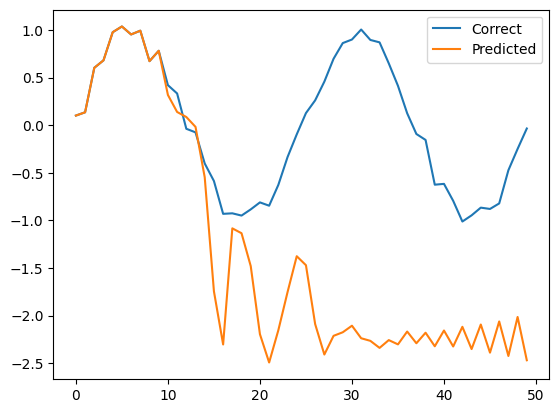

Epoch:11/101 Error:0.9783264739287276


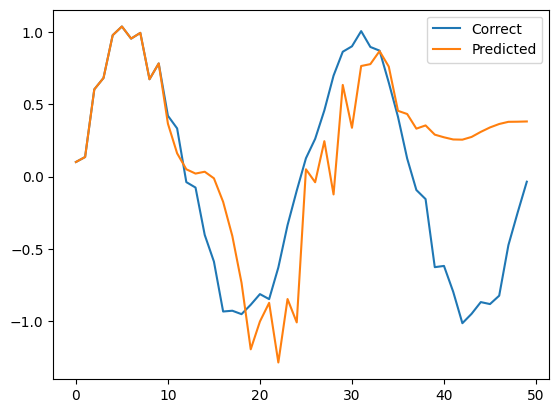

Epoch:21/101 Error:0.5553880471390439


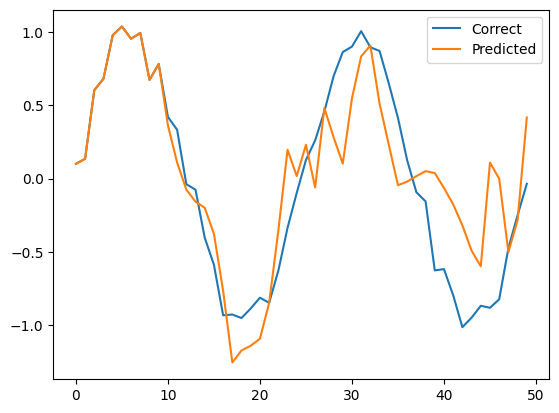

Epoch:31/101 Error:0.3613138884557591


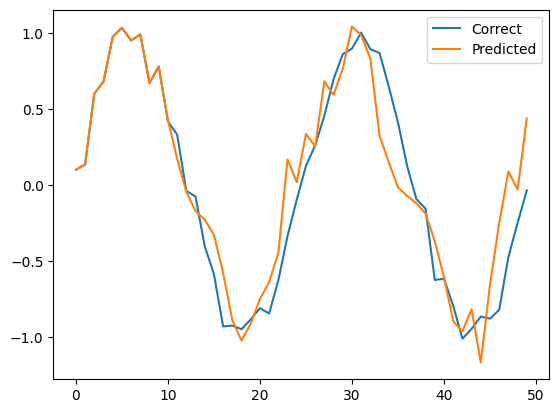

Epoch:41/101 Error:0.25958137513812357


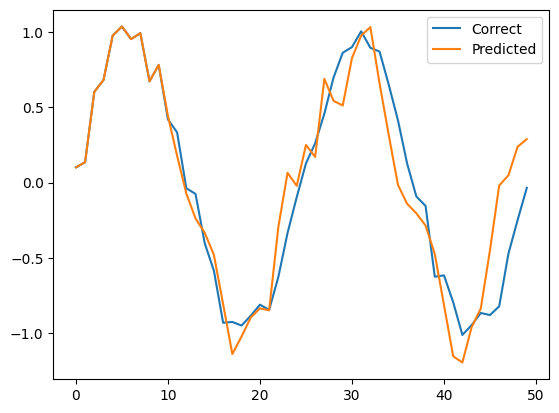

Epoch:51/101 Error:0.19964043173946572


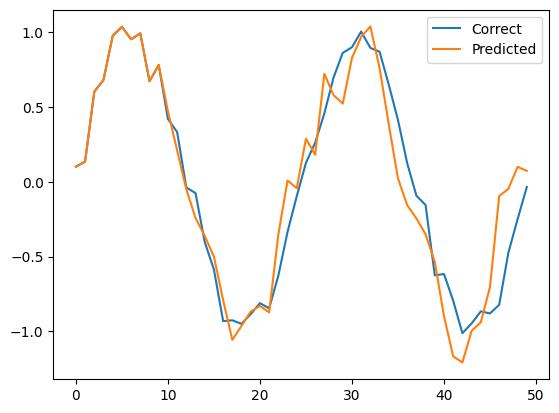

Epoch:61/101 Error:0.16371389351435084


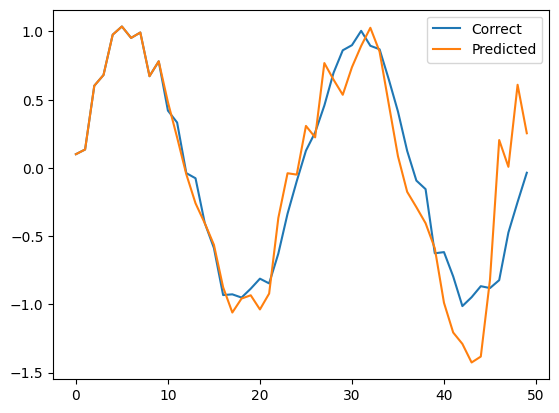

Epoch:71/101 Error:0.14092086333404122


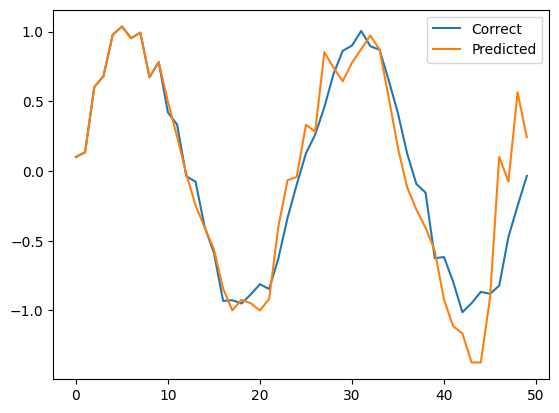

Epoch:81/101 Error:0.12913940877602695


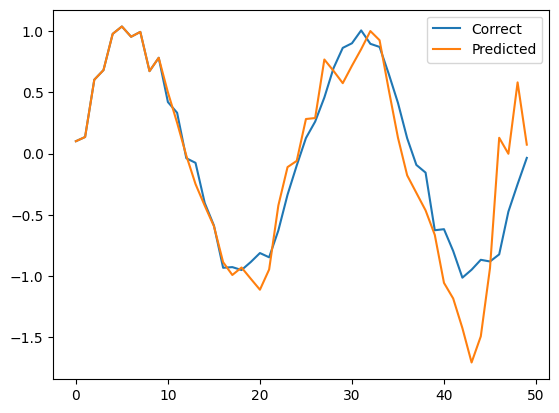

Epoch:91/101 Error:0.11672893373514442


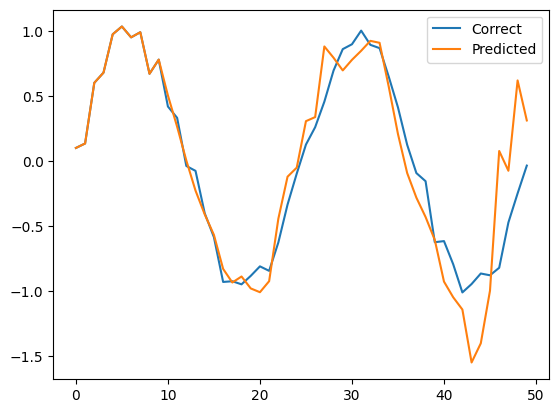

Epoch:101/101 Error:0.10964211978038411


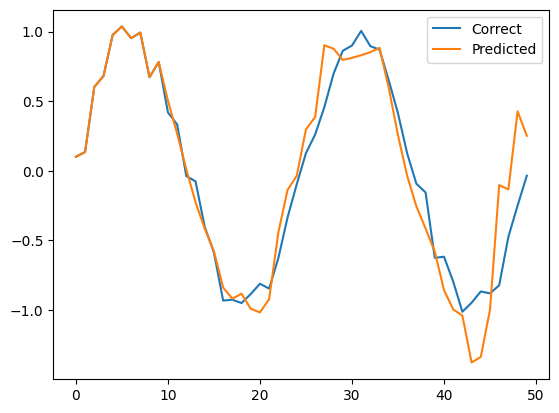

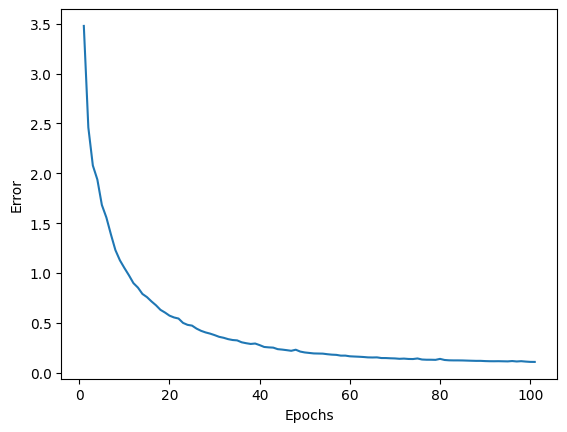

In [19]:
error_record = []
n_batch = len(input_data) // batch_size  #  # 1에포크당 배치 개수
for i in range(epochs):
    index_random = []
    for index in range(len(input_data)):
        index_random.append(index)
    random.shuffle(index_random)

    for j in range(n_batch):
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = []
        t_mb = []
        for index in mb_index:
            x_mb.append(input_data[index])
            t_mb.append(correct_data[index])
        train(x_mb, t_mb)
        #break
    #break
    error = get_error(input_data, correct_data)
    error_record.append(error)
    
     # -- 경과 표시 --
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))
        predicted = []
        for j in input_data[0]:#reshape(-1) 수행
            predicted.append(j[0])
        
        pre_start_index = 0
        for i in range(n_sample):
            x = [] #np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            for j in range(n_time):
                x.append([predicted[pre_start_index+j]])
            #print("x\n-----------\n",np.array(x))
            x = [x]
            y = predict(x)
            #print("Y",np.array(y))
            predicted.append(float(y[0][0]))  # # 출력을 predicted에 추가
            pre_start_index += 1
        #print("p",np.array(predicted))    
        plt.plot(range(len(sin_y)), sin_y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
    #break
plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()